In [18]:
# ==========================================
# 0. Import thư viện
# ==========================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.base import clone
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


In [19]:
# ==========================================
# 1. Đọc dữ liệu – giữ giống fraud-detection cũ
# ==========================================

# Đường dẫn cũ trong notebook: 'C:\\uit\\elliptic\\transaction_dataset.csv'
# Bạn chỉnh lại cho phù hợp với máy của bạn.
DATA_PATH = r"D:\elliptic\Ethereum Fraud Detection Dataset\transaction_dataset.csv"

df = pd.read_csv(DATA_PATH, index_col=0)
print("Raw shape:", df.shape)
display(df.head())

# Bỏ 2 cột đầu (Index, Address)
df = df.iloc[:, 2:]
print("Sau khi bỏ 2 cột đầu:", df.shape)


Raw shape: (9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


Sau khi bỏ 2 cột đầu: (9841, 48)


In [20]:
# ==========================================
# 2. Xử lý biến object, missing, cột phương sai 0
#    (bám sát logic notebook fraud-detection cũ)
# ==========================================

# a) Xác định các cột kiểu object -> xem thử
categories = df.select_dtypes('O').columns
print("Các cột object (categorical) ban đầu:")
print(categories.tolist())

# Trong notebook cũ: "# Drop the two categorical features"
# Ở đây ta drop toàn bộ cột object giống ý tưởng đó.
if len(categories) > 0:
    df.drop(columns=categories, inplace=True)
    print("\nĐã drop các cột object. Shape:", df.shape)

# b) Điền missing bằng median cho tất cả cột numeric
df = df.apply(pd.to_numeric, errors="coerce")  # đảm bảo numeric
df.fillna(df.median(), inplace=True)

print("\nSau fillna median – số missing còn lại mỗi cột:")
print(df.isna().sum().sort_values(ascending=False).head())

# c) Bỏ cột phương sai 0
no_var = df.var() == 0
zero_var_cols = df.var()[no_var].index.tolist()
print("\nCác cột có phương sai = 0:")
print(zero_var_cols)

if zero_var_cols:
    df.drop(columns=zero_var_cols, inplace=True)
    print("Shape sau khi drop zero-variance:", df.shape)


Các cột object (categorical) ban đầu:
[' ERC20 most sent token type', ' ERC20_most_rec_token_type']

Đã drop các cột object. Shape: (9841, 46)

Sau fillna median – số missing còn lại mỗi cột:
FLAG                                       0
Avg min between sent tnx                   0
Avg min between received tnx               0
Time Diff between first and last (Mins)    0
Sent tnx                                   0
dtype: int64

Các cột có phương sai = 0:
[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
Shape sau khi drop zero-variance: (9841, 39)


In [21]:
# ==========================================
# 3. Drop các cột phân bố quá kì quặc (giống cell 'drops')
# ==========================================

# Trong notebook cũ có đoạn:
# drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
# df.drop(drops, axis=1, inplace=True)

drop_cols = ['min value sent to contract', ' ERC20 uniq sent addr.1']

existing_drop_cols = [c for c in drop_cols if c in df.columns]
if existing_drop_cols:
    df.drop(columns=existing_drop_cols, inplace=True)
    print("Đã drop cột:", existing_drop_cols)
else:
    print("Không tìm thấy các cột trong drop_cols, bỏ qua bước này.")

print("Shape cuối cùng của df:", df.shape)
display(df.head())


Đã drop cột: ['min value sent to contract', ' ERC20 uniq sent addr.1']
Shape cuối cùng của df: (9841, 37)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 uniq rec addr,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,54.0,58.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,5.0,7.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,7.0,8.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,11.0,11.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,23.0,27.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0


In [22]:
# ==========================================
# 4. Tách X, y (giữ logic: y là cột đầu, X là phần còn lại)
# ==========================================

y = df.iloc[:, 0].astype(int)   # nhãn (0/1)
X = df.iloc[:, 1:]
print("X shape:", X.shape, "y shape:", y.shape)

print("\nPhân bố nhãn toàn bộ data:")
print(y.value_counts())


X shape: (9841, 36) y shape: (9841,)

Phân bố nhãn toàn bộ data:
FLAG
0    7662
1    2179
Name: count, dtype: int64


In [23]:
# ==========================================
# 5. Chia train / val / test = 70 / 15 / 15 có stratify (style BLTE)
# ==========================================

TEST_SIZE = 0.15
VAL_SIZE  = 0.15

# Bước 1: tách TEST trước (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# Bước 2: tách TRAIN & VAL từ phần còn lại
val_ratio_in_temp = VAL_SIZE / (1.0 - TEST_SIZE)  # ~0.1765

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio_in_temp,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

def show_stats(name, yy):
    yy = np.asarray(yy)
    counts = np.bincount(yy)
    n0 = counts[0] if len(counts) > 0 else 0
    n1 = counts[1] if len(counts) > 1 else 0
    ratio = n1 / (n0 + n1) if (n0 + n1) > 0 else 0
    print(f"{name:5s}: 0 = {n0:7d}, 1 = {n1:5d}, scam_ratio = {ratio:.6f}")

print("Shapes:")
print("  Train:", X_train.shape, y_train.shape)
print("  Val  :", X_val.shape,   y_val.shape)
print("  Test :", X_test.shape,  y_test.shape)

print("\n=== Phân bố nhãn sau khi chia ===")
show_stats("ALL",   y)
show_stats("Train", y_train)
show_stats("Val",   y_val)
show_stats("Test",  y_test)


Shapes:
  Train: (6888, 36) (6888,)
  Val  : (1476, 36) (1476,)
  Test : (1477, 36) (1477,)

=== Phân bố nhãn sau khi chia ===
ALL  : 0 =    7662, 1 =  2179, scam_ratio = 0.221421
Train: 0 =    5363, 1 =  1525, scam_ratio = 0.221400
Val  : 0 =    1149, 1 =   327, scam_ratio = 0.221545
Test : 0 =    1150, 1 =   327, scam_ratio = 0.221395


In [24]:
# ==========================================
# 6. Chuẩn hoá feature (StandardScaler – giống BLTE)
# ==========================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

feature_cols = X.columns.tolist()
print("Số lượng feature:", len(feature_cols))


Số lượng feature: 36


In [25]:
# ==========================================
# 7. AutoML đơn giản cho 1 model (Random search trên F1 macro VAL)
#    (style giống BLTE: không k-fold, chỉ train/val)
# ==========================================

def sample_param(dist, rng):
    """
    Lấy 1 giá trị từ distribution:
    - Nếu là scipy.stats (randint, uniform, …) -> dist.rvs
    - Nếu là list/tuple -> chọn random 1 phần tử
    """
    if hasattr(dist, "rvs"):
        return dist.rvs(random_state=rng)
    dist = list(dist)
    return dist[rng.randint(0, len(dist))]

def random_search_single_model(
    name,
    base_estimator,
    param_dist,
    X_train, y_train,
    X_val,   y_val,
    n_iter=30,
    random_state=42,
):
    rng = np.random.RandomState(random_state)
    best_f1_macro = -1.0
    best_params = None

    for i in range(n_iter):
        params = {}
        for k, dist in param_dist.items():
            params[k] = sample_param(dist, rng)

        model = clone(base_estimator)
        model.set_params(**params)
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)

        # chọn F1 macro trên val để đánh giá (giống kiểu BLTE dùng macro)
        f1_macro = f1_score(y_val, y_val_pred, average="macro")

        print(f"[{name}] iter {i+1:02d}/{n_iter:02d} – F1_macro(val) = {f1_macro:.4f}")

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_params = params

    print(f"\n>>> {name} – BEST F1_macro(val) = {best_f1_macro:.4f}")
    print("Best params:", best_params)

    # Train lại trên TRAIN+VAL với best_params trước khi test
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])

    best_model = clone(base_estimator)
    best_model.set_params(**best_params)
    best_model.fit(X_train_full, y_train_full)

    return best_model


In [26]:
# ==========================================
# 8. AutoML cho 3 model: RF, XGB, LGBM (giống BLTE)
# ==========================================

# 8.1 RandomForest
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_param_dist = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 50),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"],
    "criterion": ["gini", "entropy"],
}

best_rf = random_search_single_model(
    "RandomForest",
    rf_base,
    rf_param_dist,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    n_iter=30,
    random_state=RANDOM_STATE
)


[RandomForest] iter 01/30 – F1_macro(val) = 0.9604
[RandomForest] iter 02/30 – F1_macro(val) = 0.9698
[RandomForest] iter 03/30 – F1_macro(val) = 0.9709
[RandomForest] iter 04/30 – F1_macro(val) = 0.9679
[RandomForest] iter 05/30 – F1_macro(val) = 0.8835
[RandomForest] iter 06/30 – F1_macro(val) = 0.9727
[RandomForest] iter 07/30 – F1_macro(val) = 0.9688
[RandomForest] iter 08/30 – F1_macro(val) = 0.9578
[RandomForest] iter 09/30 – F1_macro(val) = 0.9762
[RandomForest] iter 10/30 – F1_macro(val) = 0.9606
[RandomForest] iter 11/30 – F1_macro(val) = 0.9515
[RandomForest] iter 12/30 – F1_macro(val) = 0.9624
[RandomForest] iter 13/30 – F1_macro(val) = 0.9719
[RandomForest] iter 14/30 – F1_macro(val) = 0.9577
[RandomForest] iter 15/30 – F1_macro(val) = 0.9688
[RandomForest] iter 16/30 – F1_macro(val) = 0.8993
[RandomForest] iter 17/30 – F1_macro(val) = 0.9519
[RandomForest] iter 18/30 – F1_macro(val) = 0.9716
[RandomForest] iter 19/30 – F1_macro(val) = 0.9660
[RandomForest] iter 20/30 – F1_

In [27]:
# 8.2 XGBoost
xgb_base = XGBClassifier(
    random_state=RANDOM_STATE,
    tree_method="hist",      # nếu có GPU: "gpu_hist"
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_param_dist = {
    "n_estimators": randint(300, 800),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),         # [0.6, 1.0]
    "colsample_bytree": uniform(0.6, 0.4),  # [0.6, 1.0]
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "objective": ["binary:logistic"],       # thường giữ nguyên cái này
    "eval_metric": ["logloss", "aucpr"],    # cho AutoML thử 2 metric
}


best_xgb = random_search_single_model(
    "XGBoost",
    xgb_base,
    xgb_param_dist,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    n_iter=30,
    random_state=RANDOM_STATE
)


[XGBoost] iter 01/30 – F1_macro(val) = 0.9793
[XGBoost] iter 02/30 – F1_macro(val) = 0.9783
[XGBoost] iter 03/30 – F1_macro(val) = 0.9764
[XGBoost] iter 04/30 – F1_macro(val) = 0.9793
[XGBoost] iter 05/30 – F1_macro(val) = 0.9782
[XGBoost] iter 06/30 – F1_macro(val) = 0.9752
[XGBoost] iter 07/30 – F1_macro(val) = 0.9793
[XGBoost] iter 08/30 – F1_macro(val) = 0.9793
[XGBoost] iter 09/30 – F1_macro(val) = 0.9822
[XGBoost] iter 10/30 – F1_macro(val) = 0.9822
[XGBoost] iter 11/30 – F1_macro(val) = 0.9723
[XGBoost] iter 12/30 – F1_macro(val) = 0.9732
[XGBoost] iter 13/30 – F1_macro(val) = 0.9773
[XGBoost] iter 14/30 – F1_macro(val) = 0.9813
[XGBoost] iter 15/30 – F1_macro(val) = 0.9753
[XGBoost] iter 16/30 – F1_macro(val) = 0.9802
[XGBoost] iter 17/30 – F1_macro(val) = 0.9783
[XGBoost] iter 18/30 – F1_macro(val) = 0.9783
[XGBoost] iter 19/30 – F1_macro(val) = 0.9762
[XGBoost] iter 20/30 – F1_macro(val) = 0.9813
[XGBoost] iter 21/30 – F1_macro(val) = 0.9802
[XGBoost] iter 22/30 – F1_macro(va

In [37]:
# 8.3 LightGBM
lgbm_base = LGBMClassifier(
    random_state=RANDOM_STATE,
    objective="binary",
    n_jobs=-1
)

lgbm_param_dist = {
    "n_estimators": randint(300, 800),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),         # [0.6, 1.0]
    "colsample_bytree": uniform(0.6, 0.4),  # [0.6, 1.0]
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "objective": ["binary:logistic"],       # thường giữ nguyên cái này
    "eval_metric": ["logloss", "aucpr"],    # cho AutoML thử 2 metric
}

best_lgbm = random_search_single_model(
    "LightGBM",
    lgbm_base,
    lgbm_param_dist,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    n_iter=30,
    random_state=RANDOM_STATE
)


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric


LightGBMError: Unknown objective type name: binary:logistic

In [36]:
# ==========================================
# 9. Đánh giá trên TEST (theo style BLTE)
# ==========================================

models = {
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
    "LightGBM": best_lgbm
}

for name, model in models.items():
    print(f"\n===== {name} trên TEST =====")
    y_pred_test = model.predict(X_test_scaled)

    acc      = accuracy_score(y_test, y_pred_test)
    f1_scam  = f1_score(y_test, y_pred_test)                    # mặc định pos_label=1
    f1_micro = f1_score(y_test, y_pred_test, average="micro")
    f1_macro = f1_score(y_test, y_pred_test, average="macro")

    print("Accuracy:", acc)
    print("F1 (scam – binary, pos_label=1):", f1_scam)
    print("F1 micro:", f1_micro)
    print("F1 macro:", f1_macro)

    print("\nclassification_report:")
    print(classification_report(y_test, y_pred_test, digits=4))

    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred_test))



===== RandomForest trên TEST =====
Accuracy: 0.979011509817197
F1 (scam – binary, pos_label=1): 0.9523809523809523
F1 micro: 0.979011509817197
F1 macro: 0.969460124475322

classification_report:
              precision    recall  f1-score   support

           0     0.9853    0.9878    0.9865      1150
           1     0.9568    0.9480    0.9524       327

    accuracy                         0.9790      1477
   macro avg     0.9710    0.9679    0.9695      1477
weighted avg     0.9790    0.9790    0.9790      1477

Confusion matrix:
[[1136   14]
 [  17  310]]

===== XGBoost trên TEST =====
Accuracy: 0.983750846310088
F1 (scam – binary, pos_label=1): 0.9627329192546584
F1 micro: 0.983750846310088
F1 macro: 0.9761716544325241

classification_report:
              precision    recall  f1-score   support

           0     0.9853    0.9939    0.9896      1150
           1     0.9779    0.9480    0.9627       327

    accuracy                         0.9838      1477
   macro avg     0.981

Background SHAP size: (2000, 36)
Explain SHAP size   : (1477, 36)

================ SHAP cho RandomForest ================


 99%|===================| 2911/2954 [01:01<00:00]        

  sv_pos.shape = (1477, 36) | ndim = 2


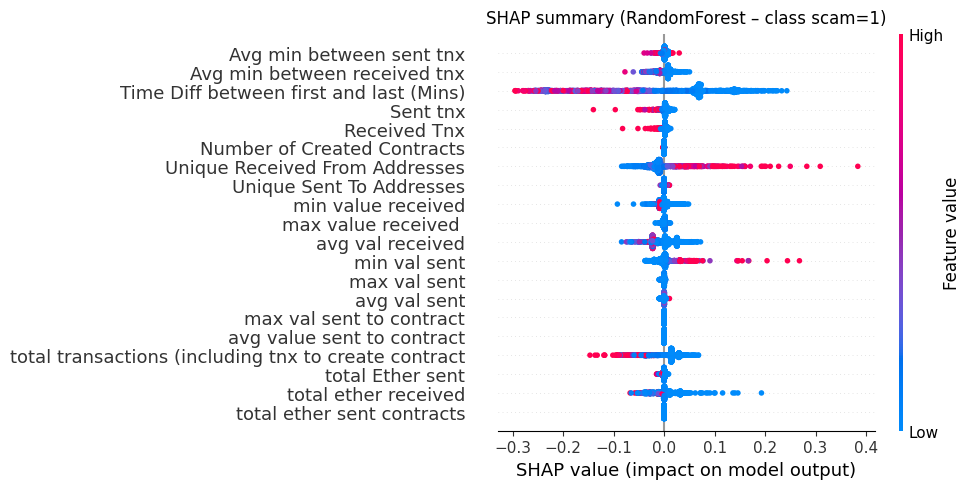

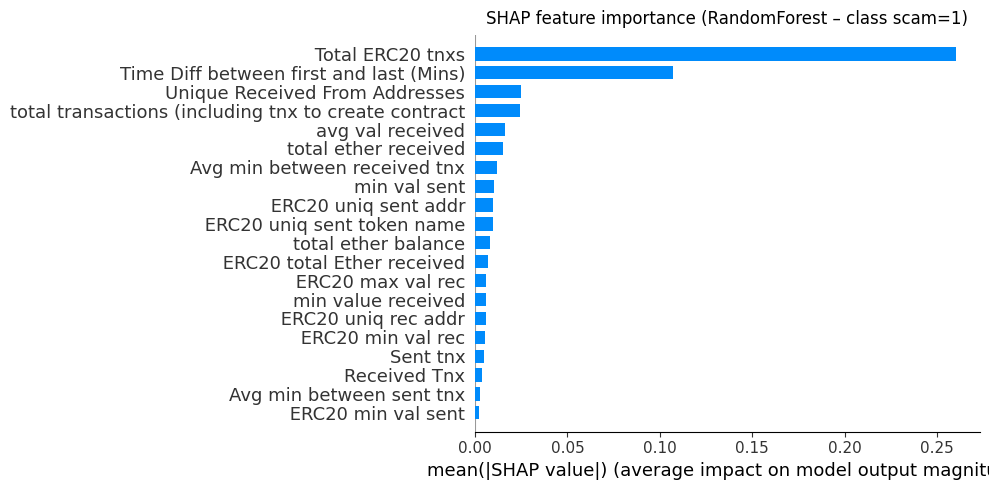


================ SHAP cho XGBoost ================
  sv_pos.shape = (1477, 36) | ndim = 2


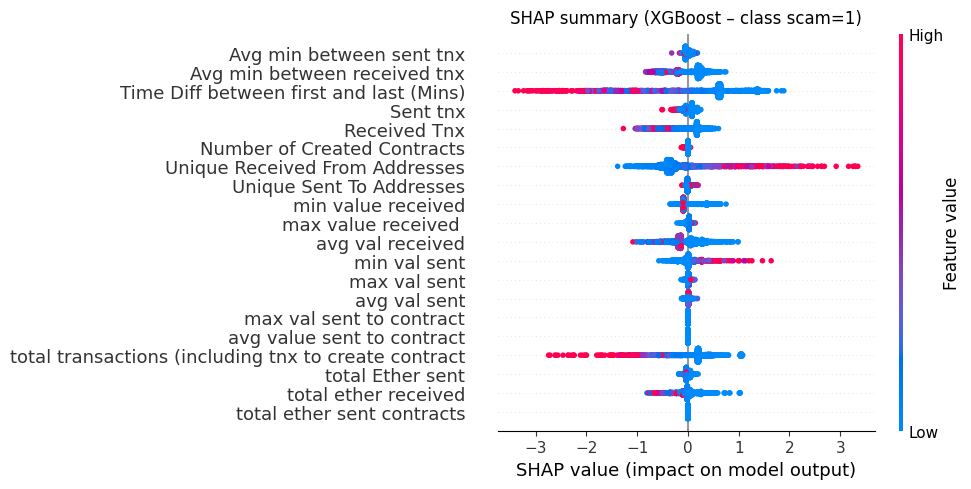

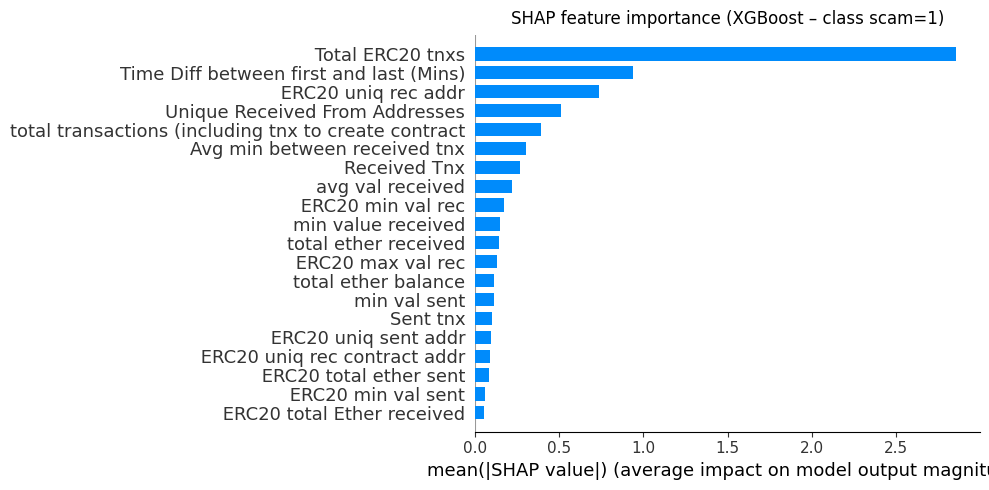


================ SHAP cho LightGBM ================


 99%|===================| 1464/1477 [00:31<00:00]        

  sv_pos.shape = (1477, 36) | ndim = 2


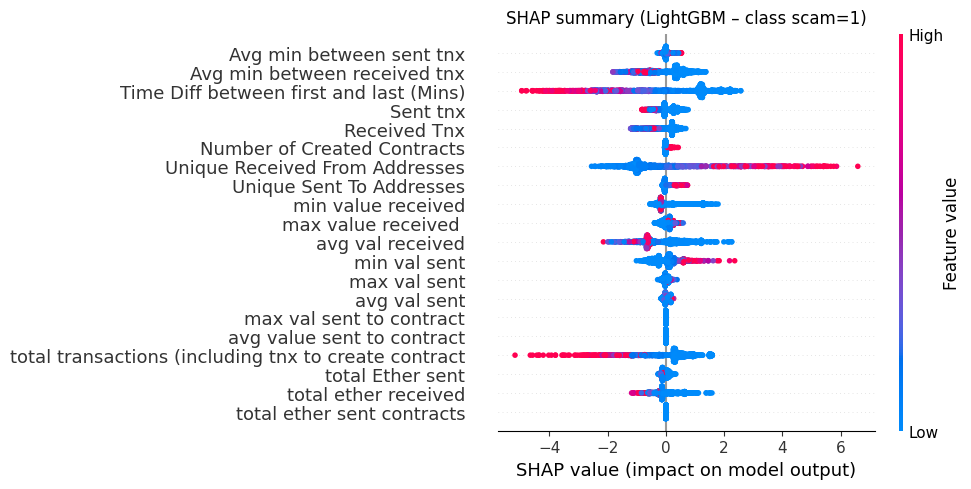

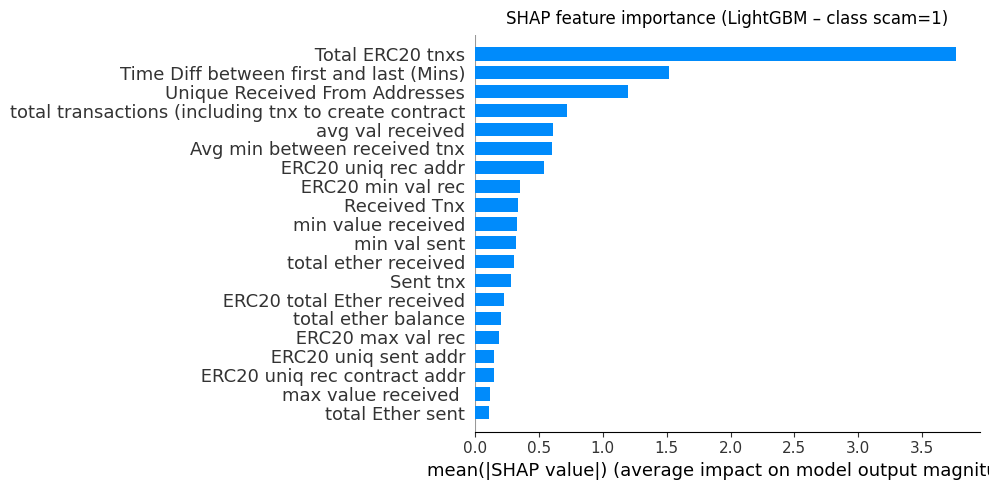


===== Local SHAP cho 1 transaction – XGBoost =====
True label      : 0
Model predicted : 0


In [32]:
# ==========================================
# SHAP cho 3 model: RF, XGB, LGBM (CHỈ SHAP VALUE)
# ==========================================
import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()


# background + sample để giải thích (giống BLTE)
n_background = min(2000, X_train_scaled.shape[0])
n_explain    = min(2000, X_test_scaled.shape[0])

X_background = X_train_scaled[:n_background]
X_explain    = X_test_scaled[:n_explain]

print(f"Background SHAP size: {X_background.shape}")
print(f"Explain SHAP size   : {X_explain.shape}")

for name, model in models.items():
    print(f"\n================ SHAP cho {name} ================")

    expl = shap.TreeExplainer(
        model,
        data=X_background,
        feature_perturbation="interventional"
    )

    # ---- CHỈ DÙNG shap_values, KHÔNG interaction ----
    sv = expl.shap_values(
        X_explain,
        check_additivity=False
    )

    # ----- Chuẩn hoá về SHAP cho class=1, sv_pos: (n_samples, n_features) -----
    # Trường hợp 1: shap trả về list [class0, class1]
    if isinstance(sv, list):
        if hasattr(model, "classes_"):
            cls_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            cls_idx = 1
        sv_pos = np.array(sv[cls_idx])

        ev = expl.expected_value
        if isinstance(ev, (list, np.ndarray)):
            expected_pos = np.array(ev)[cls_idx]
        else:
            expected_pos = ev

    # Trường hợp 2: shap trả về array 3D (n_samples, n_features, n_classes)
    elif isinstance(sv, np.ndarray) and sv.ndim == 3:
        if hasattr(model, "classes_"):
            cls_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            # fallback: nếu không có classes_, chọn lớp cuối cùng
            cls_idx = sv.shape[2] - 1

        # bóc lớp cuối cùng -> (n_samples, n_features)
        sv_pos = np.array(sv[:, :, cls_idx])

        ev = expl.expected_value
        if isinstance(ev, (list, np.ndarray)):
            ev = np.array(ev)
            if ev.ndim == 1 and ev.shape[0] >= cls_idx + 1:
                expected_pos = ev[cls_idx]
            else:
                expected_pos = ev
        else:
            expected_pos = ev

    # Trường hợp 3: shap trả về array 2D sẵn
    else:
        sv_pos = np.array(sv)
        expected_pos = expl.expected_value

    print("  sv_pos.shape =", sv_pos.shape, "| ndim =", sv_pos.ndim)
    # Nếu vẫn 3D là biết ngay đang có chuyện lạ
    assert sv_pos.ndim == 2, "sv_pos vẫn không phải 2D, SHAP trả format lạ (có thể là interaction)."

    # ===== 1) Summary plot dạng dot =====
    shap.summary_plot(
        sv_pos,
        X_explain,
        feature_names=feature_cols,
        sort=False,      # giữ nguyên thứ tự feature (giống BLTE)
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.title(f"SHAP summary ({name} – class scam=1)", pad=8)
    plt.tight_layout()
    plt.show()

    # ===== 2) Feature importance dạng bar =====
    shap.summary_plot(
        sv_pos,
        X_explain,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.title(f"SHAP feature importance ({name} – class scam=1)", pad=8)
    plt.subplots_adjust(top=0.85, left=0.25)
    plt.tight_layout()
    plt.show()


# ==========================================
# Local explanation cho 1 transaction bằng XGBoost (giống BLTE)
# ==========================================
idx = 0  # transaction muốn giải thích
main_model_name = "XGBoost"
model = models[main_model_name]

print(f"\n===== Local SHAP cho 1 transaction – {main_model_name} =====")
print("True label      :", y_test.iloc[idx])
print("Model predicted :", model.predict(X_test_scaled[idx:idx+1])[0])

expl_local = shap.TreeExplainer(
    model,
    data=X_background,
    feature_perturbation="interventional"
)
sv_local = expl_local.shap_values(
    X_explain,
    check_additivity=False
)

# Chuẩn hoá như trên, nhưng chỉ cho XGB
if isinstance(sv_local, list):
    if hasattr(model, "classes_"):
        cls_idx = int(np.where(model.classes_ == 1)[0][0])
    else:
        cls_idx = 1
    sv_local_pos = np.array(sv_local[cls_idx])

    ev_local = expl_local.expected_value
    if isinstance(ev_local, (list, np.ndarray)):
        ev_local_pos = np.array(ev_local)[cls_idx]
    else:
        ev_local_pos = ev_local

elif isinstance(sv_local, np.ndarray) and sv_local.ndim == 3:
    if hasattr(model, "classes_"):
        cls_idx = int(np.where(model.classes_ == 1)[0][0])
    else:
        cls_idx = sv_local.shape[2] - 1

    sv_local_pos = np.array(sv_local[:, :, cls_idx])
    ev = np.array(expl_local.expected_value)
    ev_local_pos = ev[cls_idx] if ev.ndim == 1 else ev

else:
    sv_local_pos = np.array(sv_local)
    ev_local_pos = expl_local.expected_value

assert sv_local_pos.ndim == 2, "sv_local_pos vẫn không phải 2D!"

shap.force_plot(
    ev_local_pos,
    sv_local_pos[idx, :],
    X_explain[idx, :],
    feature_names=feature_cols
)
